# Redes Neuronales Recurrentes (RNR)/ Recurrent Neuronal Networks (RNN)

## Parte 1 - Preprocesado de los datos

In [19]:
#Importación de las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Importar el dataset de entrenamiento
dataset_train = pd.read_csv("Google_Stock_Price_Train.csv")
training_set = dataset_train.iloc[:, 1:2].values

In [3]:
# Escalado de las características
# Mejor usar la normalización en lugar de la estandarización

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range= (0,1)) # el más pequeño será 0 y el más grande 1. No hace falta porue es así por defecto
training_set_scaled = sc.fit_transform(training_set)                

In [4]:
# Crear una estructura de datos con 60 timesteps y 1 salida
# 60 timesteps-> en cada momento del tiempo la red neuronal será capaz de mirar 60 días atrás
X_train =[]
y_train =[]
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i,0]) # para cada día a partir de 60 miramos 60 días antes
    y_train.append(training_set_scaled[i, 0]) # y la etiqueta será ese día
X_train, y_train = np.array(X_train), np.array(y_train) # Para que sean objetos de numpy

In [5]:
# Redimensión de los datos
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# ha pasado de (1198, 60) a (1198, 60, 1) -> 1198 filas, 60 columnas y 1 dimensión 

En Keras (y en la mayoría de librerías), una RNN / LSTM espera los datos de entrada con esta forma:


· n_muestras → el número de ejemplos de entrenamiento (aquí 1198).

· timesteps → cuántos pasos de tiempo mira la red (aquí 60 días).

· n_features → cuántas variables hay en cada día (en cada timestep).

En mi caso:

Cada día sólo tienes 1 feature: el precio de apertura (Open).

Por eso n_features = 1.


Si algún día meto más variables por día, por ejemplo:
Open, High, Low, Volume, tendrías:

4 features por día → n_features = 4.

La forma sería (1198, 60, 4).


Si hubiésemos cogido más de una característica (columna) -> No haría falta hacer expand porque ya tiene 3 dimensiones

X_train = []
y_train = []

for i in range(60, 1258):
    # TODAS las columnas (Open, High, Close)
    X_train.append(training_set_scaled[i-60:i, :])
    
    # → objetivo: predecir solo OPEN (columna 0)
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)




## Parte 2 - Construcción de la RNR

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Input

In [7]:
# Inicialización del modelo
regressor= Sequential() #Regresión porque queremos predecir unos valores continuos

In [8]:
# Añadimos la primera capa de LSTM y la regularización por Dropout
regressor.add(Input(shape = (X_train.shape[1], 1, ))) #No incluyo X_train.shape[0] porque la info (instancias) pueden ir por bloques
regressor.add(LSTM(units=50, return_sequences= True))
#Es interesante que units sea alto ya que con pocas neuronas LST no podrá calculara correlaciones avnzadas. Calcularía sólo  las obvios
# return_sequences =True -> Para que se transmita la info a la siguiente capa de LSTM
regressor.add(Dropout(0.2)) # Para desactivar algunas neuronas de la capa anterior previniendo el overfitting. En LSTM se suele poner un rate supeior a CNN: entre 10 y 20%
# Añadir la segunda capa de LSTM y la regularización por Dropout. Al aumentar la dimensión espero poder lidiar con el problema
regressor.add(LSTM(units=50, return_sequences= True))

regressor.add(Dropout(0.2))

# Añadir la tercera capa de LSTM y la regularización por Dropout

regressor.add(LSTM(units=50, return_sequences= True))
regressor.add(Dropout(0.2))

# Añadir la cuarta capa de LSTM y la regularización por Dropout

regressor.add(LSTM(units=50, return_sequences= False)) # return_sequences= False porque es la última capa (No se tiene que conectar con otra) o lo elimino porque está False por defecto
regressor.add(Dropout(0.2))

In [9]:
# Añadir la capa de salida

regressor.add(Dense(units = 1))

In [10]:
# Compilar la RNR
regressor.compile(optimizer='adam', loss = 'mean_squared_error')

#Como es regresión la función de optimización será diferente a la de clasificación
#Predecimos valores. Uno de los más utilizados es RMSprop: Root Mean Squared Prop. Es el recomendado para Redes Neuronales Recurrentes.
#Otra opción es el optimizador de adam, que es el que mejor resultado ha dado en estos casos
#loss. No queremos minimizar el error de clasificación sino minimizar la diferencia entre el error de la predicción y el del dato ->dif al cuadrado entre predicción y variable objetivo real. Error cuadrático medio (RMSE) 

In [11]:
# Ajustar la RNR a nuestro conjunto de entrenamiento
regressor.fit(X_train,y_train, epochs=100,batch_size= 32)

Epoch 1/100
38/38 [==============================] - 8s 58ms/step - loss: 0.0355
Epoch 2/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0061
Epoch 3/100
38/38 [==============================] - 2s 54ms/step - loss: 0.0062
Epoch 4/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0054
Epoch 5/100
38/38 [==============================] - 2s 58ms/step - loss: 0.0056
Epoch 6/100
38/38 [==============================] - 2s 58ms/step - loss: 0.0054
Epoch 7/100
38/38 [==============================] - 2s 57ms/step - loss: 0.0048
Epoch 8/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0041
Epoch 10/100
38/38 [==============================] - 2s 59ms/step - loss: 0.0053
Epoch 11/100
38/38 [==============================] - 3s 67ms/step - loss: 0.0041
Epoch 12/100
38/38 [==============================] - 2s 61ms/step - loss: 0.0042
Epoch 13/100
38/38 [=====

## Parte 3 - Ajustar las predicciones y visualizar los resultados

In [12]:
# Obtener el valor real de las acciones de Enero de 2017

dataset_test = pd.read_csv("Google_Stock_Price_Test.csv")
real_stock_price = dataset_test.iloc[:, 1:2].values

In [13]:
# Predecir las acciones de enero de 2017 con la RNR
# Para el primer día, los 60 anteriores estarán en 2016, que está en el training set
# ¡¡¡Muy importante!!! -> Todos los datos tienen  que estar bajo un mismo factor de escala

# 1) Concatenamos ambos datasets, cogiendo sólo la columna 'Open'

dataset_total = pd.concat((dataset_train['Open'],dataset_test['Open']), axis = 0) #axis = 0 -> Para unir los datos por filas
inputs = dataset_total[len(dataset_total)- len(dataset_test) -60:].values # último día de 2016 - 60 días hacia adelante -> resultado vector fila (80,) ->.reshape(-1,1)
inputs= inputs.reshape(-1,1) # pasa a (80,1). Quiere decir deja la dimensión que hay como está (-1) y añade una más (1)
# Utilizamos el escalador de antes para escalar inputs
inputs = sc.transform(inputs) # No hacemos un fit porque el mínimo y el máximo ya se tiene (está entrenado). Sólo hay que transformar


In [21]:
X_test = []

for i in range(60, 80): #Día 60 es el 1er día de 2017: OK - 80 (60 + 20 días que quiero predecir)
    X_test.append(inputs[i-60:i, :])
    
X_test = np.array(X_test) # da una matriz 2D de numpy pero la RNN necesita 3D

In [22]:
# Redimensión de los datos
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# ha pasado de (1198, 60) a (1198, 60, 1) -> 1198 filas, 60 columnas y 1 dimensión 

In [23]:
predicted_stock = regressor.predict(X_test)

1/1 [==============================] - 0s 30ms/step


In [24]:
# Hay que revertir el scaler
predicted_stock_price= sc.inverse_transform(predicted_stock)

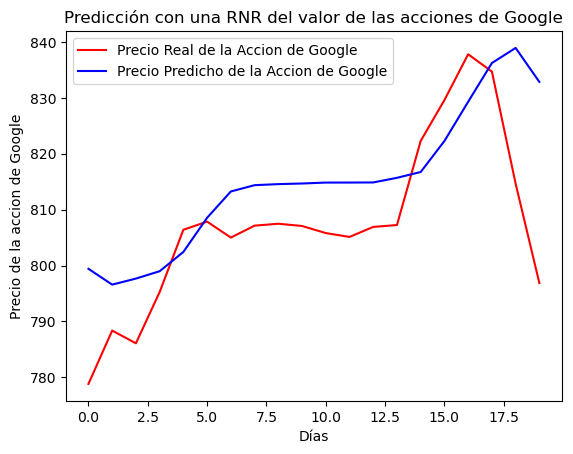

In [26]:
# Visualizar los resultados

plt.plot(real_stock_price, color ='red', label = 'Precio Real de la Accion de Google')
plt.plot(predicted_stock_price, color ='blue', label = 'Precio Predicho de la Accion de Google')
plt.title("Predicción con una RNR del valor de las acciones de Google")
plt.xlabel("Días")
plt.ylabel("Precio de la accion de Google")
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

12.73034878404014